In [99]:
import sage.logic.propcalc as pc
import itertools as it
#import numpy.random as rn
#from sage.plot.histogram import Histogram
import numpy as np

from scipy.stats import spearmanr
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Defin the Boolean Rules
Rules = """E2F1 *= (~pRB & E2F1) | (~pRB & Myc)
CyclinD1 *= (~p21 & Myc) | (~pRB & Myc & E2F1) | (~p21 & E2F1) | (~pRB & E2F1 & CyclinD1)
p21 *= ~CyclinE
Myc *= ~pRB & E2F1
CyclinE *= ~pRB & ~p27Kip1 & E2F1
pRB *= (p27Kip1 & ~CyclinD1) | (~CyclinE & ~CyclinD1)
p27Kip1 *= ~CyclinE & ~CyclinD1"""

In [3]:
# Parse the rules
rdict = {}
for line in Rules.split('\n'):
    lr = line.split('*=')
    rdict[lr[0].strip()] = pc.formula(lr[1])
    
for r in rdict: print r, "*=", rdict[r]

E2F1 *= (~pRB&E2F1)|(~pRB&Myc)
CyclinE *= ~pRB&~p27Kip1&E2F1
pRB *= (p27Kip1&~CyclinD1)|(~CyclinE&~CyclinD1)
p27Kip1 *= ~CyclinE&~CyclinD1
p21 *= ~CyclinE
CyclinD1 *= (~p21&Myc)|(~pRB&Myc&E2F1)|(~p21&E2F1)|(~pRB&E2F1&CyclinD1)
Myc *= ~pRB&E2F1


In [4]:
# Convert the rules to Hill rate functions
x={r:var('x_'+r) for r in rdict}
RF = {}
for r in rdict:
    k = {}
    n = {}
    H = {}
    
    RF[r] = -x[r]
    
    varnames = str(rdict[r].truthtable(end=0)).split()[0:-1]
    
    for ncomb in range(len(varnames)+1):
        for comb in it.combinations(varnames,ncomb):
            st = {v: v in list(comb) for v in varnames}
            hprod = 0
            if rdict[r].evaluate(st):           
                hprod = 1
                for v in varnames:
                    rv = r + '_' + v
                    k[rv] = var('k_' + rv)
                    n[rv] = var('n_' + rv)
                    
                    if st[v]:
                        hprod *= x[v]^n[rv] / (k[rv]^n[rv] + x[v]^n[rv])
                    else:
                        hprod *= k[rv]^n[rv] / (k[rv]^n[rv] + x[v]^n[rv])
            RF[r] += hprod
    RF[r] = ((RF[r]+x[r]).numerator()/(RF[r]+x[r]).denominator()) - x[r]

In [5]:
# Define the class that hold parameter sets for each motif
class SMRoot:
    Nscan = 20
    tscan = [i/Nscan for i in range(1,Nscan+1)]
    lowroot = 0.499
    highroot = 1
    eps = 0.001

    def __init__(self,paramDict):
        self.paramDict=paramDict
        self.maxRootDict = {}
        self.tested = False
        
    def buildMaxRoot(self):
        return

In [6]:
# Read in the parameter simulation results for each motif
NSM1 = load('./NSM1.sobj')
SM1 = load('./SM1.sobj')
strongSM1 = load('./strongSM1.sobj')

NSM2 = load('./NSM2.sobj')
SM2 = load('./SM2.sobj')
strongSM2 = load('./strongSM2.sobj')

NSM3 = load('./NSM3.sobj')
SM3 = load('./SM3.sobj')
strongSM3 = load('./strongSM3.sobj')

In [28]:
# Put strongly functional parameter sets into matrix form and compute correlations

kss1 = sorted(SM1[0].paramDict.keys(), key=lambda x: str(x))
ObsSM1 = np.array([[sm.paramDict[kk] for kk in kss1] for sm in strongSM1])
ObsSM1=ObsSM1.transpose()
SpCSM1,pSpCSM1=spearmanr(np.transpose(ObsSM1))

kss2 = sorted(SM2[0].paramDict.keys(), key=lambda x: str(x))
ObsSM2 = np.array([[sm.paramDict[kk] for kk in kss2] for sm in strongSM2])
ObsSM2=ObsSM2.transpose()
SpCSM2,pSpCSM2=spearmanr(np.transpose(ObsSM2))

kss3 = sorted(SM3[0].paramDict.keys(), key=lambda x: str(x))
ObsSM3 = np.array([[sm.paramDict[kk] for kk in kss3] for sm in strongSM3])
ObsSM3=ObsSM3.transpose()
SpCSM3,pSpCSM3=spearmanr(np.transpose(ObsSM3))

In [29]:
# Define more intuitive labels labels
ks1 = [str(kk).split('_')[0]+': '+str(kk).split('_')[1]+'->'+str(kk).split('_')[2] for kk in kss1]
ks2 = [str(kk).split('_')[0]+': '+str(kk).split('_')[1]+'->'+str(kk).split('_')[2] for kk in kss2]
ks3 = [str(kk).split('_')[0]+': '+str(kk).split('_')[1]+'->'+str(kk).split('_')[2] for kk in kss3]

In [24]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

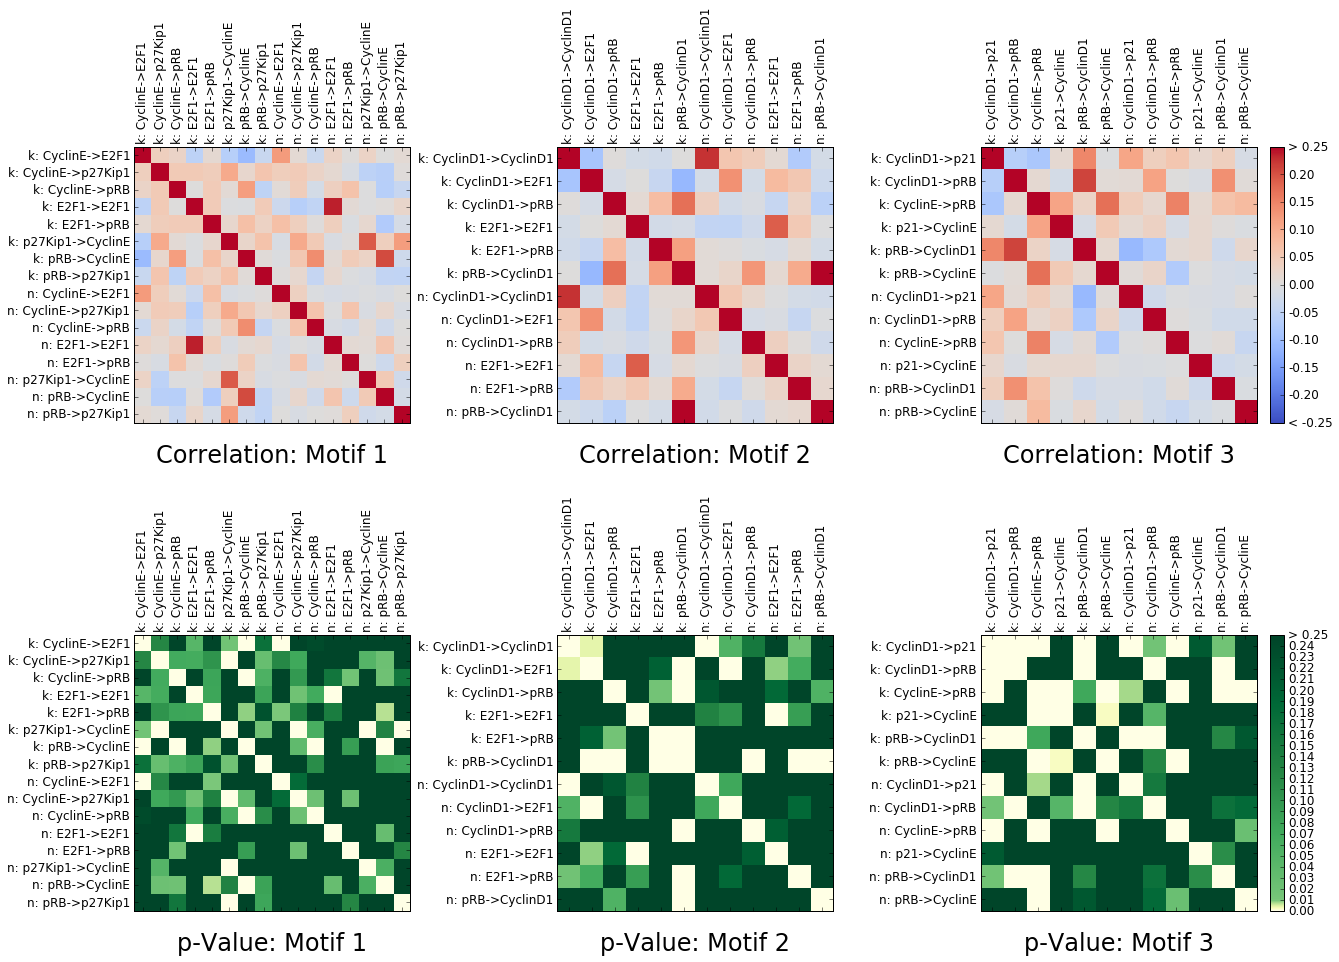

In [155]:
gp, ((s1, s2, s3, cs), (p1, p2, p3, cp)) = plt.subplots(ncols=4,nrows=2,figsize=(23,15), gridspec_kw={"width_ratios":[1,1,1,0.05]})

fs = 12

s1.matshow(SpCSM1,vmin=-.25,vmax=.25,cmap='coolwarm')
plt.sca(s1.get_axes())
plt.xticks(range(len(ks1)),ks1,fontsize=fs,rotation=90)
plt.yticks(range(len(ks1)),ks1,fontsize=fs)
plt.xlabel('Correlation: Motif 1',fontsize=2*fs,labelpad=20)

p1.matshow(pSpCSM1,vmin=0,vmax=0.25,cmap=shiftedColorMap(matplotlib.cm.YlGn,midpoint=0.01*4, name='shifted'))
plt.sca(p1.get_axes())
plt.xticks(range(len(ks1)),ks1,rotation=90, fontsize=fs)
plt.yticks(range(len(ks1)),ks1,fontsize=fs)
plt.xlabel('p-Value: Motif 1',fontsize=2*fs,labelpad=20)

s2.matshow(SpCSM2,vmin=-.25,vmax=.25,cmap='coolwarm')
plt.sca(s2.get_axes())
plt.xticks(range(len(ks2)),ks2,rotation=90,fontsize=fs)
plt.yticks(range(len(ks2)),ks2,fontsize=fs)
plt.xlabel('Correlation: Motif 2',fontsize=2*fs,labelpad=20)

p2.matshow(pSpCSM2,vmin=0,vmax=0.25,cmap=shiftedColorMap(matplotlib.cm.YlGn,midpoint=0.01*4, name='shifted'))
plt.sca(p2.get_axes())
plt.xticks(range(len(ks2)),ks2,rotation=90, fontsize=fs)
plt.yticks(range(len(ks2)),ks2,fontsize=fs)
plt.xlabel('p-Value: Motif 2',fontsize=2*fs,labelpad=20)

gpa=s3.matshow(SpCSM3,vmin=-.25,vmax=.25,cmap='coolwarm')
plt.sca(s3.get_axes())
plt.xticks(range(len(ks3)),ks3,rotation=90,fontsize=fs)
plt.yticks(range(len(ks3)),ks3,fontsize=fs)
plt.xlabel('Correlation: Motif 3',fontsize=2*fs,labelpad=20)

gpb=p3.matshow(pSpCSM3,vmin=0,vmax=0.25,cmap=shiftedColorMap(matplotlib.cm.YlGn,midpoint=0.01*4, name='shifted'))
plt.sca(p3.get_axes())
plt.xticks(range(len(ks3)),ks3,rotation=90, fontsize=fs)
plt.yticks(range(len(ks3)),ks3,fontsize=fs)
plt.xlabel('p-Value: Motif 3',fontsize=2*fs,labelpad=20)

gp.subplots_adjust(hspace=0.4,wspace=0.7)

ip = InsetPosition(s3, [1.05,0,0.05,1]) 
cs.set_axes_locator(ip)
cbars=gp.colorbar(gpa, cax=cs, ax=[s1,s2,s3])
cbars.set_ticks([0.05*i for i in range(-5,6)])
cbars.set_ticklabels(['< -0.25'] + [str(0.05*i)[0:5] for i in range(-4,0)]+[str(0.05*i)[0:4] for i in range(5)] + ['> 0.25'])
cbars.ax.tick_params(labelsize=fs) 

ip = InsetPosition(p3, [1.05,0,0.05,1]) 
cp.set_axes_locator(ip)
cbarp=gp.colorbar(gpb, cax=cp, ax=[p1,p2,p3])
cbarp.set_ticks([0.01*i for i in range(26)])
cbarp.set_ticklabels([str(0.01*i)[0:4] for i in range(25)]+['> 0.25'])
cbarp.ax.tick_params(labelsize=fs) 

plt.savefig('correlation array plot.png',bbox_inches='tight')
plt.show()
